In [1]:
"""
Attempt to remove the background (RFI) using the dark sky file...

Not sure if this is correct.
"""

'\nAttempt to remove the background (RFI) using the dark sky file...\n\nNot sure if this is correct.\n'

In [2]:
import sys
import time

import astropy.units as u
import h5py
import matplotlib.pyplot as plt
import numpy as np

from multiprocessing import Pool

from astropy.units import Quantity
from matplotlib import dates
from sunpy.time import TimeRange

/home/ofionnad/realta/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
sys.path.insert(0,"/home/ofionnad/scripts")
from raw_class import LofarRaw

In [4]:
##So here is a background subtraction from Pearse, but I do not use it. Including it here in case it is required in the future

In [5]:
def bg(data, amount=0.05):
        #tmp = data - np.mean(data, axis=0) 
        sdevs = np.mean(data, 1)
        cand = sorted(range(data.shape[0]), key=lambda y: sdevs[y])
        realcand = cand[:max(1, int(amount*len(cand)))]
        bg = np.mean(data[realcand, :], 0)
        return bg

In [6]:
### Reading Code

In [10]:

start = time.time() #just some brief profiling

############ Observation settings, change these for each observation
#fname = sys.argv[1]
fname = 'udpoutput/jupiter-2beams-stokesV_0_2020-10-13T17:47:00_19563125244140'
trange = TimeRange("2020/10/13 17:47:00", 10*u.min)
frange = [15,60]*u.MHz
sbs = np.arange(76, 319) # for 2/4 beams
#sbs = np.arange(76, 197)  # for 1/4 beam
obs_mode = 3
time_decimation = 16
dt = 5.12e-6 * time_decimation
resample_bool = True
resampled_dt = 1e-3
###########################################################

############# Dark file details ###########################
dfname = 'udpoutput/dark-stokesV_0_2020-10-13T17:47:00_19563125244140'
dfrange = [15,40]*u.MHz
dsbs = np.arange(76, 197)
###########################################################

########## Plotting settings ##############################
title = "Jupiter - Stokes V - dark subtracted"
xtitle = "Time"
ytitle = "Frequency (MHz)"
savestring = "rawplot_source_darksub_15_60MHz.png"
###########################################################

#define raw object with data etc.
raw = LofarRaw(fname, sbs, obs_mode, trange, frange, dt=dt)
draw = LofarRaw(dfname, dsbs, obs_mode, trange, dfrange, dt=dt)
read_time = time.time() - start #profiling
print("\nTime to read raw data: {:.6f} sec\n".format(read_time))

### Resampling the data in time, helps with memory (loses resolution!)
if resample_bool:
    #### source data ####
    resample_start = time.time()
    sum_int = int(np.floor(resampled_dt/raw.dt.sec))
    sum_shape = int(np.round(raw.data.shape[1]/sum_int))

    def resample(i):
        return np.sum(raw.data[:,i*sum_int:(i+1)*sum_int], axis=1)
    def dresample(i):
        return np.sum(draw.data[:,i*sum_int:(i+1)*sum_int], axis=1)

    with Pool() as pool:
        resample_data = pool.map(resample, range(sum_shape))

    resample_data = np.array(resample_data)
    resample_data = np.ma.masked_equal(resample_data, 0.05)
    
    #### dark data ####
    sum_int = int(np.floor(resampled_dt/draw.dt.sec))
    sum_shape = int(np.round(draw.data.shape[1]/sum_int))
    
    with Pool() as pool:
        dresampled = pool.map(dresample, range(sum_shape))
    
    dresampled = np.array(dresampled)
    dresampled = np.ma.masked_equal(dresampled, 0.05)
    
    resample_time = time.time() - resample_start
    print("Time to resample the data : {:.6f} sec".format(resample_time))
else:
    resample_data = np.array(raw.data)
    dresampled = np.array(raw.data)

### This focuses on the frequencies where the data overlaps with calibration data
s_data = resample_data[:,0:119]
d_data = dresampled
#bg_data = rs_data / bg(rs_data, 0.05)

print("\nData processing done\n")


Time to read raw data: 0.006098 sec

Time to resample the data : 29.976385 sec

Data processing done



In [19]:
s_data = resample_data[:,0:119]

In [20]:
print(s_data.shape, d_data.shape)

(610352, 119) (610352, 119)


In [ ]:
### Plotting 

In [21]:
def plotter(ds, i_data):
    """
    ds : input dataset (LofarRaw object)
    i_data : the derived output data that you want to plot
    """
    
    print("Creating figure... ... ...\n")

    fig, ax = plt.subplots(figsize=(10,6))
    if raw.trange is None:
        ax.imshow(i_data.data.T, aspect='auto', 
            extent=[ds.obs_start.plot_date, ds.obs_end.plot_date,
            ds.freqs[-1].value, ds.freqs[0].value],
            vmin=np.percentile(i_data.data, 5), vmax=np.percentile(i_data.data,95))
    else:
        ax.imshow(i_data.data.T, aspect='auto',
            extent=[ds.trange.start.plot_date, ds.trange.end.plot_date,
            ds.freqs[-1].value, ds.freqs[0].value],
            vmin=np.percentile(i_data.data, 5), vmax=np.percentile(i_data.data, 95))

    print("...\nImage created!\n...\n")
    date_format = dates.DateFormatter("%H:%M:%S")
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(date_format)
    ax.set_title(title)
    ax.set_xlabel(xtitle)
    ax.set_ylabel(ytitle)
    print("\nSaving Figure!\n")
    plt.savefig(savestring)
    #plt.savefig(str(raw.obs_start)+"_raw_"+str(int(frange[0]))+"_"+str(int(frange[1]))+"MHz.png")
    end = time.time() - start
    print("Time to run: {:.6f} sec\n=======================".format(end))
    plt.show()

In [15]:
###vispy could speed up the plotting stuff here (but would take time to work out)

Creating figure... ... ...

...
Image created!
...


Saving Figure!

Time to run: 405.708032 sec


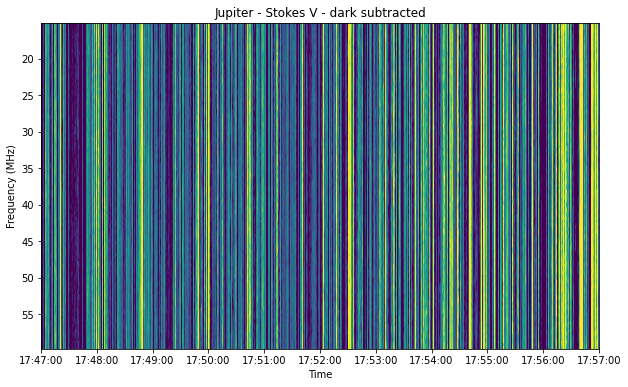

In [22]:
plotter(raw, s_data)